# Data Fundamentals (H)
John H. Williamson -- Session 2020/2021

----

**This submission must be your own work; you will have to make a Declaration of Originality on submission.**



---

# Data Fundamentals (H)
John H. Williamson   -- Session 2021/2022

## Lab 4: Assessed
# Vector spaces and linear transforms

## Purpose of this lab
This lab should help you:
* understand how data can be represented as points in vector space
* understand the effect of different vector norms
* apply linear transforms to vectors
* apply principal component analysis using eigendecompositions

## Guidance
You will need to understand the following functions well to complete this lab:
* [`np.argmin()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.argmin.html) [Unit 1]
* [`np.argsort()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.argsort.html) [Unit 1]
* [`np.linalg.norm()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.norm.html) [Unit 4]
* [`np.linalg.svd()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.svd.html) [Unit 5]
* [`np.linalg.eig()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.eig.html) [Unit 5]
* [`np.cov()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.cov.html) [Unit 4]


In [ ]:
# you can optionally install this module to clean up the plots in the later part of the lab
# it doesn't affect anything if you don't do so
# %pip install --user --no-cache adjustText

In [1]:
# Standard imports
# Make sure you run this cell!
# NumPy
import numpy as np  
import binascii

# do nothing if not installed
try:
    from adjustText import adjust_text    
except:
    adjust_text = lambda *args, **kwargs: None
    
# Set up Matplotlib
import matplotlib as mpl   
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('figure', figsize=(8.0, 4.0), dpi=140)

# custom utils  
from jhwutils.checkarr import array_hash, check_hash
import jhwutils.image_audio as ia
import jhwutils.tick as tick

def case_crc(s):
    h_crc =  binascii.crc32(bytes(s.lower(), 'ascii'))
    print(h_crc)
    return h_crc

# ignore any warnings below, they don't affect the results
print("Everything imported OK")

Everything imported OK


C:\ProgramData\Anaconda3\lib\site-packages\IPython\kernel\__init__.py:12: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  warn("The `IPython.kernel` package has been deprecated since IPython 4.0."


## Whisky: Representing and comparing vectors

Whisky distillation is a major industry in Scotland. 

<img src="imgs/stills.jpg"> <br><br>*.[Image](https://flickr.com/photos/sashafatcat/518104633 "stills") by [sashafatcat](https://flickr.com/people/sashafatcat) shared [CC BY](https://creativecommons.org/licenses/by/2.0/)*

The dataset in `data/whisky.csv` is data from a number of whisky distilleries. For each distillery, there is a set of subjective judgements about the flavour characteristics of their product. The data comes from [this Strathclyde University research project](https://www.mathstat.strath.ac.uk/outreach/nessie/nessie_whisky.html).

Each distillery has been judged on twelve flavour indicators (like "smokiness" or "sweetness"), and they have been assigned values from 0-5, indicating the strength of that category as judged by an expert whisky drinker. These can be seen as 12D vectors, one vector per distillery. **Every distillery is represented as a point in twelve dimensional vector space.**

We also have an array of the geographical locations of each distillery as 2D points on a map. The code below loads the data.

## Loading the data

In [2]:
## It is not necessary to understand this code to complete
# the exercise. We don't cover pandas in DF(H)
import pandas as pd

whisky_df = pd.read_csv("data/whiskies.txt")
whisky_df = whisky_df.sort_values(by="Distillery")
# extract the column and row names
distilleries = np.array(whisky_df["Distillery"])

columns = {name.lower(): index for index, name in enumerate(whisky_df.columns[2:-3])}
column_indices = {index:name.lower() for index, name in enumerate(whisky_df.columns[2:-3])}

# split apart the data frame and form numpy arrays
locations = np.array(whisky_df.iloc[:, -2:])
whisky = np.array(whisky_df.iloc[:, 2:-3])
np.set_printoptions(suppress=True)
# fix wine column which is misnamed
columns["wine"] = columns["winey"]
del columns["winey"]
# force tie breaks
np.random.seed(2018)
whisky = whisky + np.random.uniform(0, 1.0, whisky.shape)

## Viewing the data
We can see this whole dataset as a heatmap:

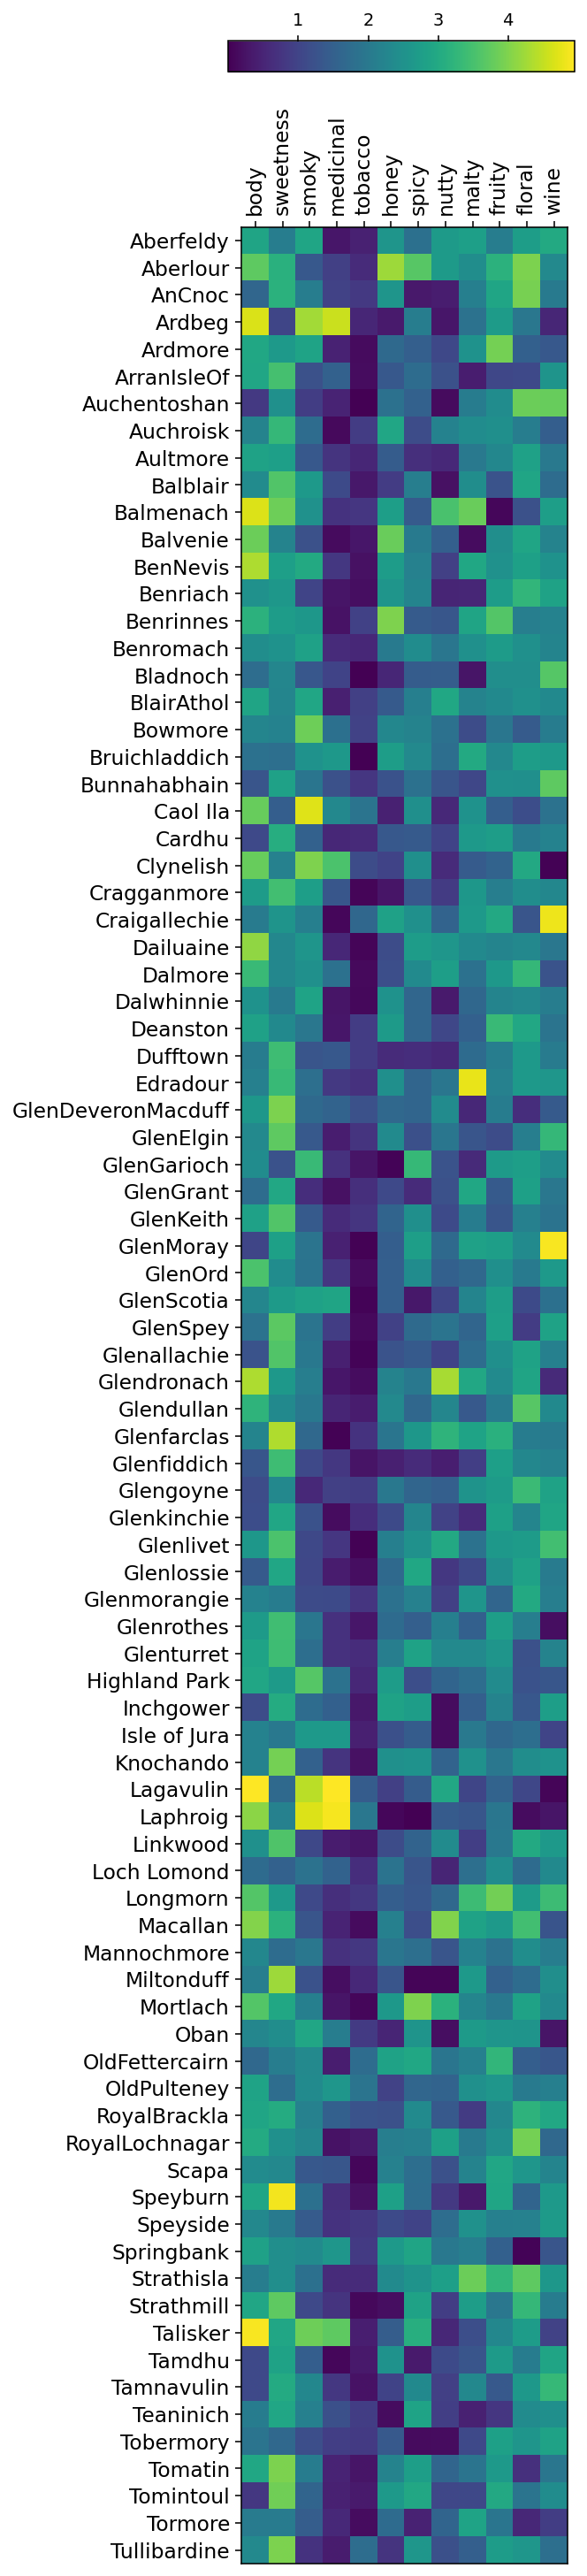

In [3]:
# show a plot of the whisky data
fig = plt.figure(figsize=(10,25))
ax = fig.add_subplot(1,1,1)

# image plot
img = ax.imshow(whisky)
ax.set_yticks(np.arange(len(distilleries)))
ax.set_yticklabels(distilleries, rotation="horizontal", fontsize=12)

# put the x axis at the top
ax.xaxis.tick_top()
ax.set_xticks(np.arange(len(columns)))
ax.set_xticklabels(columns, rotation="vertical", fontsize=12)

# some horrific colorbar hackery to put in the right place
# don't worry about this bit!
cbaxes = fig.add_axes([0.37, 0.93, 0.28, 0.01])  
fig.colorbar(img, orientation='horizontal',  cax=cbaxes, ticks=np.arange(5))
cbaxes.xaxis.tick_top()

### Available data
You now have these variables:

* `whisky` an  86x12 array of taste judgements, one row for each of the 86 distilleries. Each whisky has a rating 0-5 for each of the 12 flavour categories.
* `locations` is an 86x2 matrix of positions of each distillery in [OS grid reference format](https://www.gridreferencefinder.com/) in the same order as `whisky`
* `distilleries` is a list of 86 distillery names
* `columns` is a mapping of feature names to column indices.
* `column_indices` maps indices to column (feature) names

For example:

In [10]:
print(whisky[distilleries.searchsorted('Glenfiddich'), 
             columns['smoky']])

1.0897226718562112


will tell you how "smoky" Glenfiddich was rated.

In [11]:
print(columns["smoky"], column_indices[4])

2 tobacco


will tell you the column index of `smoky` and the name of column `4`

In [12]:
print(whisky[distilleries.searchsorted('Glenfiddich')])

[1.32664113 3.42010124 1.08972267 0.80801688 0.26109704 0.43601682
 0.6115702  0.42135283 0.92576906 2.80226673 2.29784509 2.16788936]


will print the whole set of flavour profiles for Glenfiddich.

In [13]:
print(distilleries[8]) # distilleries is just a list of names

Aultmore


will tell you the 9th distillery in the dataset is `Aultmore`.

In [14]:
print(locations[distilleries.searchsorted('Glengoyne')])

[252810 682750]


will tell you where to find the Glengoyne distillery in UK OS grid units.

## A: Norms, interpolation and statistics
We will see some simple things we can do with this dataset. 


We can compute distances in **flavour space** between distilleries.

For example, we can compute the distance between the `Glenlivet` distillery and every other distillery *in terms of flavour, not physical distance*. The result will be a 1D array of 86 distances. 

Remember: distance between $\vec{x}$ and $\vec{y}$ is the norm of their difference: $\|\vec{x}-\vec{y}\|$

We can compute this for several different norms (e.g. $L_1, L_2$, and $L_\infty$)

We start by subtracting the flavour vector for `Glenlivet` from all the other flavour vectors in the `whisky` matrix.

We then use `np.linalg.norm` to compute the norm of every row vector in the resulting matrix. We set `axis=1` to ensure that norms are calculated "across columns", i.e. the norm of each row vector is calculated. We also specify which norm we want to calculate (`1` for $L_1$, `2` for $L_2$ or `np.inf` for $L_\infty$). The result is a 1D array of 86 distances in **flavour space**.

In [15]:
# Get the flavour vector for Glenlivet
glenlivet = whisky[distilleries.searchsorted("Glenlivet")]
print(glenlivet) # 12 numbers, in the range 0-5

[2.62286833 3.54181922 1.07385158 0.78503541 0.02922946 2.14009029
 2.51030532 2.98123896 1.85897206 2.64742671 2.72418747 3.44808261]


In [16]:
## Compute distances
# must use axis=1 to get the right result, otherwise the matrix norm will be used
# (the matrix norm is calculated across the whole matrix, rather than across each row vector!)
glenlivet_2 = np.linalg.norm(whisky - glenlivet, 2, axis=1)  # L_2 norm


### Visualising these distances
We can visualise these distances. This lets us see which distilleries produce whisky most similar to Glenlivet and which of them are most dissimilar. Note that we can use `argsort` to order a list of distances. Below, we plot each distillery's flavour distance to `Glenlivet` as a rank bar plot (see Unit 3). The labels are a bit small, but the graph is a useful summary of the distances in this abstract 12 dimensional space.

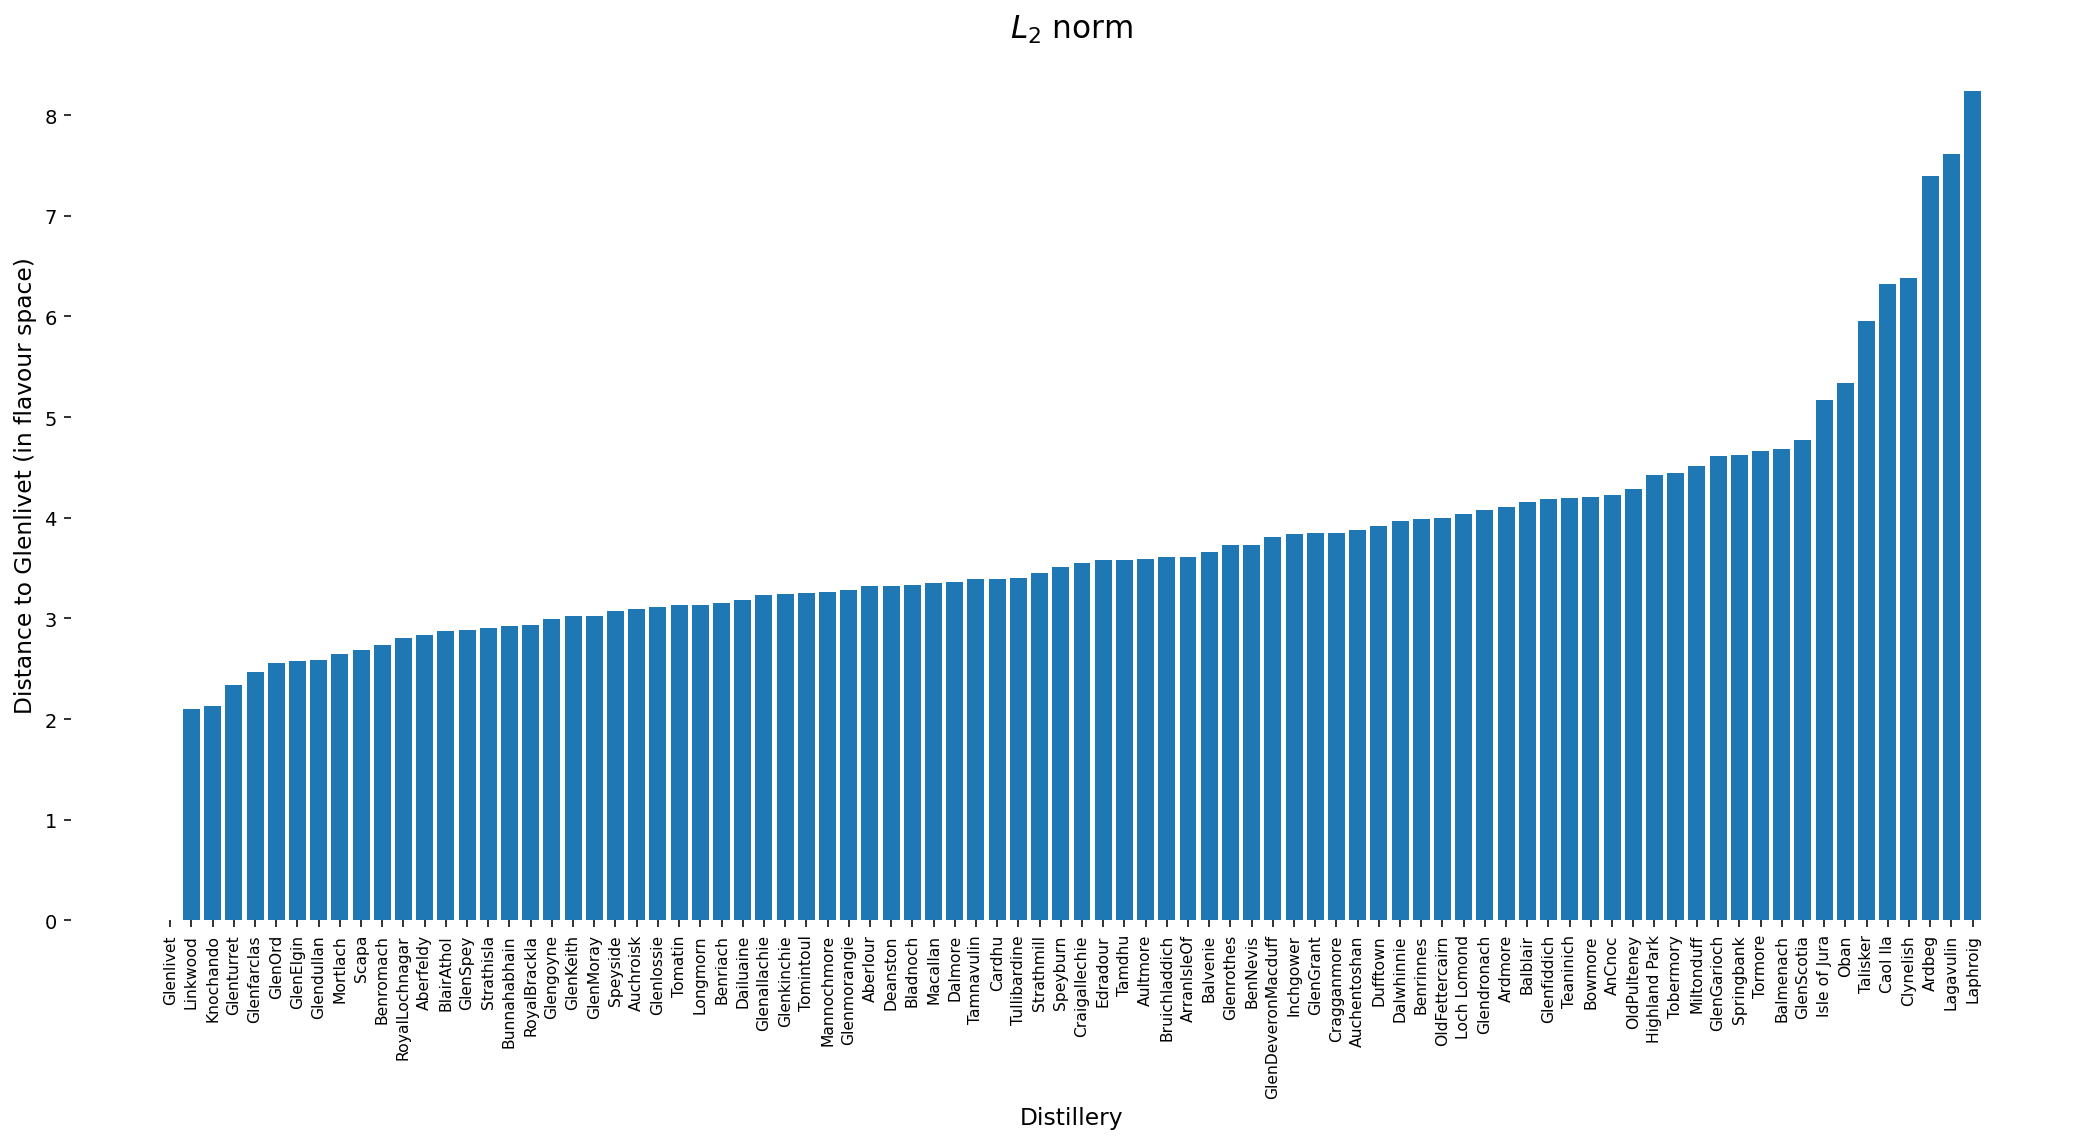

In [17]:
fig = plt.figure(figsize=(15, 22.5))

# you can use this utility function to
# help you get the xticklabels in order
def list_in_order(alist, order):
    """Given a list 'alist' and a list of indices 'order'
    returns the list in the order given by the indices"""
    return [alist[i] for i in order]


def rank_plot(distances):
    # find the ordering of the distances
    order = np.argsort(distances)
    # bar plot them
    ax.bar(np.arange(len(distances)), distances[order])
    ax.set_xlabel("Distillery", fontsize=12)
    ax.set_ylabel("Distance to Glenlivet (in flavour space)", fontsize=12)
    ax.set_xticks(np.arange(86))
    ax.set_frame_on(False)
    # make sure the same order is used for the labels!
    ax.set_xticklabels(
        list_in_order(distilleries, order), rotation="vertical", fontsize=8
    )


# make the plot
ax = fig.add_subplot(3, 1, 1)
ax.set_title("$L_2$ norm", fontsize=16)
rank_plot(glenlivet_2)

# removes ugly overlapping
plt.tight_layout()

## Tasks

**Task A.1** 

Compute the $L_1$ distance between Tomintoul and Mortlach's flavour profiles, and store it in the variable $d_1$.

In [4]:
# YOUR CODE HERE
tomintoul = distilleries.searchsorted("Tomintoul")
mortlach = distilleries.searchsorted("Mortlach")
d_1 = np.linalg.norm(whisky[tomintoul] - whisky[mortlach], ord=1)

In [5]:
with tick.marks(4):        
    assert(check_hash(d_1, ((), 55.35505212431931)))

**Task A.2** 
Which distillery is least like `Scapa`'s flavour profile in the $L_2$ norm? Store the distillery **name** in the variable in `unlike_scapa`. Note: compute this - do not hardcode it.


In [18]:
# YOUR CODE HERE
scapa = whisky[distilleries.searchsorted("Scapa")]
unlike_scapa = distilleries[np.linalg.norm(whisky - scapa, 2, axis=1).argmax()]

In [19]:
print(f"The distillery most unlike Scapa (according to the L_2 norm) is {unlike_scapa}.")

The distillery most unlike Scapa (according to the L_2 norm) is Laphroig.


In [20]:
with tick.marks(2):        
    assert(case_crc(unlike_scapa)==2291391646)

2291391646


Which distillery is *geographically closest to* Lagavulin (using L_2 norm)? (i.e. in map units, not whisky space)

In [31]:
# YOUR CODE HERE
lagavulin_loc = locations[distilleries.searchsorted('Lagavulin')]
print(lagavulin_loc)
# Choose next one after Lagavulin
nearest_lagavulin = distilleries[np.linalg.norm(locations - lagavulin_loc, ord=2, axis=1).argsort()[1]]
print(nearest_lagavulin)

[140430 645730]
Ardbeg


In [32]:
with tick.marks(2):        
    assert(case_crc(nearest_lagavulin)==3308509936)

3308509936


Which distillery is *closest to* the flavour midway point between Ardbeg and Scapa (using L_2 norm)?

In [33]:
midway = (whisky[distilleries.searchsorted('Ardbeg')] + whisky[distilleries.searchsorted('Scapa')])/2
midway_ardbeg_scapa = distilleries[
    np.argsort(np.linalg.norm(midway-whisky, ord=2, axis=1))[1]]
print(midway_ardbeg_scapa)

OldPulteney


In [34]:
with tick.marks(2):        
    assert(case_crc(midway_ardbeg_scapa)==2088351511)

2088351511


**Note** from now on, use the $L_2$ norm if you need to compute any norms.


### Vector arithmetic
A client says to you:
    
>    I'd like something a bit more "lively" than Tobermory, in the same way that Craigellachie is more "lively" than Auchentoshan.

Which whisky should you recommend? 

<div class="alert alert-info">

**Note**
* What does more "lively" mean? We don't have a "lively" column.
    * But we do have a reference point: Auchentoshan -> Craigellachie is somehow "lively"
    * This "direction" between these flavour vectors is *also* a vector
</div>

**Task A.3** Compute:

* `lively` A vector representing what "lively" is.
* `hypothetical_flavour` A vector representing a hypothetical flavour that would be a more lively version of Tobermory.
* `recommendation` the name of a specific distillery that we might recommend, as a string.
* `mild_recommendation` the name of a distillery that is a version of Tobermory that is half as "lively" as Craigellachie->Auchentoshan.

**Note: this question is not subjective, nor does it require any trial-and-error or knowledge about whisky. Answer it directly using vector arithmetic.**

In [46]:
# YOUR CODE HERE
craigellachie = distilleries.searchsorted("Craigellachie")
auchentoshan = distilleries.searchsorted("Auchentoshan")
lively = whisky[craigellachie] - whisky[auchentoshan]
tobermory = distilleries.searchsorted("Tobermony")
hypothetical_flavour = whisky[tobermory] + lively
recommendation = distilleries[np.linalg.norm(whisky - hypothetical_flavour, ord=2, axis=1).argmin()]
mild_flavour = whisky[tobermory] + lively/2
recommendation_mild = distilleries[np.linalg.norm(whisky - mild_flavour, ord=2, axis=1).argmin()]

In [42]:
print("I would recommend {distillery} as a more 'lively' version of Tobermory.".format(distillery=recommendation))

I would recommend Dailuaine as a more 'lively' version of Tobermory.


In [9]:
with tick.marks(2):
    assert(check_hash(lively, ((12,), -2.4067078581354258 )))

In [40]:
with tick.marks(2):
    assert(check_hash(hypothetical_flavour,((12,), 132.25871909606641)))

In [43]:
with tick.marks(1):
    assert(case_crc(recommendation)==2849472188)

2849472188


In [47]:
print("I would recommend {distillery} as a slightly less 'lively' version of Tobermory.".format(distillery=recommendation_mild))
with tick.marks(1):
    assert(case_crc(recommendation_mild)==95109583)

I would recommend Speyside as a slightly less 'lively' version of Tobermory.
95109583


**Task A.4** A client wishes to taste whiskies that are new to her. You have been told:

* The client has visited Scotland and tasted `Lagavulin`, `Laphroig`, and `Ardbeg`.
* She hated them.
* Find the five distilleries which are as distant as possible from the average flavour profile that the client has already experienced. 
* The client is currently visiting `Glenlivet` and wishes to have an efficient tour of Scotland, so order the distilleries to visit in order of geographical distance to Glenlivet, closest first.

Store the list of names in `new_experiences`. This should begin `Tomintoul`.


In [63]:
# YOUR CODE HERE
lagavulin = whisky[distilleries.searchsorted("Lagavulin")]
laphroig = whisky[distilleries.searchsorted("Laphroig")]
ardberg = whisky[distilleries.searchsorted("Ardberg")]
hated_whiskies = [lagavulin, laphroig, ardberg]

avg_flavour = np.mean(hated_whiskies, axis=0)
print(avg_flavour)
furthest_whiskies = np.linalg.norm(whisky - avg_flavour, ord=2, axis=1).argsort()[-5:]
print(furthest_whiskies)

new_experiences = distilleries[np.linalg.norm(locations - lagavulin_loc, ord=2, axis=1).argsort()[1]]

[3.99463288 2.17570117 3.99833513 3.43638385 1.18150635 0.90759943
 0.98340442 1.81739786 1.62825207 2.4769014  0.91584533 0.57651744]
[83 25  1 37  6]


In [ ]:
print("The recommended new experiences are:")

for distillery in new_experiences:
    print("\t", distillery)


In [ ]:
with tick.marks(4):
    assert(case_crc(new_experiences[0])==277845485)
    assert(case_crc(new_experiences[1])==1616467651)
    assert(case_crc(new_experiences[2])==1754616754)
    assert(case_crc(new_experiences[3])==2995927990)
    assert(case_crc(new_experiences[4])==3150786825)

## Region flavours

We could say that the "representative" element of a collection of vectors was the one closest to the centroid. This is given by the **mean vector** of a data set.

**Task A.5** Compute the mean vector of all of the flavour vectors. Use it to find the names of three distilleries:
* `most_representative` The distillery with the **most** representative flavour profile
* `least_representative` The distillery with the **least** representative flavour profile

In [ ]:
# YOUR CODE HERE

In [ ]:
print("The most representative whisky distillery is {most}, and the most unusual is {least}.".format(most=most_representative,
                                                                                           least=least_representative))

In [ ]:
with tick.marks(4):
    assert(case_crc(most_representative)==1877523766)
    assert(case_crc(least_representative)==2291391646)

**Task A.6** Find six distilleries as evenly spaced in *geographical location* as possible, in a straight line from `Mortlach` to `Glengoyne`. Store this sequence of names in `tour`, which should begin `Mortlach` and end `Glengoyne`.


In [ ]:
# YOUR CODE HERE

In [ ]:
print(tour)
with tick.marks(4):
    assert(case_crc(tour[0])==752256104)
    assert(case_crc(tour[1])==3620979414)
    assert(case_crc(tour[2])==2078579357)
    assert(case_crc(tour[3])==3551803812)
    assert(case_crc(tour[4])==1874522992)
    assert(case_crc(tour[5])==1743686774)


### A map
The code below will show a map of Scotland, with the distilleries in their correct positions. Different geographic regions have different characteristic flavour profiles.

Two very distinctive regions are the **island** region and the **Speyside** region. These are bounded roughly by the boxes

* [x1, y1] -> [x2, y2]
* **Island** 95000, 625000 -> 183000, 860000
* **Speyside** 263000, 785000 -> 343000,880000
    
in the same OS grid units used in the `locations` array. This is highlighted on the map below.


In [ ]:
from whisky_map import draw_map, map_box

# draw each distillery label at the locations given.
ax = draw_map(locations, distilleries)

# show the island region
# draw a box in OS grid units
map_box(ax, 95000, 625000, 183000, 860000)
map_box(ax, 263000, 785000, 343000,880000 )

**Task A.6**
* Find all distilleries in `island` and in `Speyside` and store their names in `island_distilleries` and `speyside_distilleries`. 

To help check your results, note that there are 10 island distilleries and `Ardbeg` is one; there are 60 Speyside distilleries and `Aberlour` is one.

In [ ]:
# YOUR CODE HERE

In [ ]:
with tick.marks(4):
    assert len(island_distilleries)==10
    assert len(speyside_distilleries)==60
    assert case_crc(" ".join(sorted(island_distilleries)))==687563559
    assert case_crc(" ".join(sorted(speyside_distilleries)))==424347645

Compute the following:

* `island_flavour`: Compute the most typical whisky flavour profile for island whiskies. (i.e. a 12 element vector).
* `most_typical_speyside`: The specific name of the distillery from Speyside that is most typical of that region;
* `most_atypical_island`: The specific name of the distillery *from the islands* that is most atypical of that region (i.e. furthest from the typical island flavour);
* `most_typical_outside`: The specific name of the distillery from **outside** both Speyside and the islands that is most typical of the flavour outside those regions;
* `most_like_island`: The specific name of the distillery from **outside** the islands that is most like a typical island distillery.

**Note:** do not do any of this by hand. Write code.
Hint: Boolean arrays.

In [ ]:
# YOUR CODE HERE

In [ ]:
with tick.marks(2):
    assert(check_hash(island_flavour, ((12,), 145.92133250662795 )))

In [ ]:
print("The most typical whisky of the Speyside region is {most}.".format(most=most_typical_speyside))
print("The most atypical whisky of the island region is {most}.".format(most=most_atypical_island))
print("The most typical non-island/non-Speyside whisky is {most}.".format(most=most_typical_outside))
print("The non-island whisky most like island whiskies is {nonisland}.".format(nonisland=most_like_island))       

In [ ]:
with tick.marks(2):
    assert(case_crc(most_typical_speyside)==125187962)

In [ ]:
with tick.marks(2):
    assert(case_crc(most_atypical_island)==999830981)

In [ ]:
with tick.marks(2):    
    assert(case_crc(most_typical_outside)==224181440)

In [ ]:
with tick.marks(3):    
    assert(case_crc(most_like_island)==2088351511)

## Task A.7 

Find the following quantities:
    
* `island_speyside`, the flavour vector that goes from the average Speyside to the average island whisky
* `most_distinct` the name of the element of the flavour vector that is largest in magnitude in `island_speyside`, i.e. the most relevant column name that distinguishes Speyside and island whiskies
* `midway` The name of the distillery that is closest to halfway between the *flavour profiles* of the island and Speyside regions

In [ ]:
# YOUR CODE HERE

In [ ]:
with tick.marks(2):
    assert(check_hash(island_speyside, ((12,), -14.971010372737357)))

In [ ]:
print(most_distinct)
with tick.marks(2):    
    assert(case_crc(most_distinct)==1631309389)

In [ ]:
print(midway)
with tick.marks(2):        
    assert(case_crc(most_distinct)==1631309389)


# B: Eigendecompositions and whitening
This part uses ideas from Unit 5 of the course. You may wish to wait until after the Unit 5 lecture to attempt this section. 

You are welcome to attempt it in advance, but you will have to do your own research.



## Focusing data
<img src="imgs/drop.jpg" width="40%"> <br><br>*~[Image](https://flickr.com/photos/predi/236902022 "just a droplet, but upside down") by [Predi](https://flickr.com/people/predi) shared [CC BY-ND](https://creativecommons.org/licenses/by-nd/2.0/)*

This part will use  matrix decompositions to form abstract "lenses" that let us see data from different perspectives. This will let us pull out hidden structure and translate among representations.

## B.1 Demeaning
The dataset that we have is unnormalised. It is a set of ratings, 0-5, and many of the attributes rated are very correlated (e.g. `smoky` and `medicinal`). Many of the ratings are also on quite different scales, with `tobacco` being much less likely to be rated 4 than `floral`.

It is easier to work with normalised data. 

**Task B.1**
Compute:
* `mean_vector` the average flavour profile (you should have this from part A already)
* `demeaned_whisky` that has the mean flavour vector removed. 



In [ ]:
# YOUR CODE HERE

In [ ]:
## Show the mean vector as an image strip
## Remember: this represents a point in space
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1,1,1)
img = ax.imshow(mean_vector[None,:], cmap='viridis', vmin=0, vmax=4)
ax.set_xticklabels(columns)
ax.set_xticks(np.arange(len(columns)))
ax.set_yticks([])
ax.set_title("Mean vector of flavour profile")
fig.colorbar(img, orientation='horizontal')

with tick.marks(2):
    assert(check_hash(demeaned_whisky, ((86, 12), -12953.907125105236)))

## B.2 Covariances

**Task B.2** Compute the **covariance matrix** of the *demeaned* data. Call this `whisky_cov`. 

The code below will show you this matrix as an image. **Note**: this should be a 12x12 matrix!

The covariance matrix tells us how different columns of the dataset are correlated (co-vary) with each other.

In [ ]:
# YOUR CODE HERE

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
img = ax.imshow(whisky_cov, cmap='seismic', vmin=-1.5, vmax=1.5)
ax.set_xticks(np.arange(12))
ax.set_yticks(np.arange(12))
ax.set_yticklabels(columns)
ax.set_xticklabels(columns, rotation='vertical')
ax.set_title("Covariance matrix")
fig.colorbar(img)

with tick.marks(2):
    assert(check_hash(whisky_cov, ((12, 12), 630.4802156765314)))

From the image of the covariance matrix we can see several interesting things:
* having `body` is negatively correlated with the `wine` flavour
* being `smoky` is negatively correlated with having `sweetness`
* `nutty` is positively correlated with `body`

Although the raters have provided 12 different categories, it seems these are not fully independent of each other.

## B.3 Eigendecomposition of the covariance matrix

We would like to create some new flavour categories that are independent of each other (so that we don't have categories like smoky and medicinal that are given similar numbers by the tasters). We can do this by combining the existing flavour categories.

By looking at the covariance matrix, we can get an idea of which flavours are most correlated or most independent. Let's analyse this in more detail. Recall that the covariance matrix can be represented by an ellipse whose primary axes are the **eigenvectors** of the covariance matrix. The eigenvectors are a set of *independent* directions in which the dataset varies. 

These are the **principal components** of the dataset. We can compute these from the covariance matrix by taking the eigendecomposition. Each eigenvector of the covariance matrix is a **principal component** and its importance is given by the square root of the absolute value of its corresponding eigenvalue.


**Task B.3**
* Compute all 12 of the eigenvectors of the covariance matrix, in order, with the *largest* corresponding eigenvalue first. Store these as a matrix of column vectors in `whisky_pc`. These eigenvectors are the principal components of the whisky data set.
* Compute the square root of every eigenvalue (we can think of these as lengths of the prinicipal components) and store them in `whisky_pc_len`. Make sure they are in descending order from largest to smallest.

In [ ]:
# YOUR CODE HERE

In [ ]:
## We can show the principal components as an image
## Each row is a principal component and shows a vector
## which represents the direction of variation. The first
## vector represents the largest component.
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1,1,1)
# space out the principal components and scale them by the length of the components
img = ax.imshow(np.concatenate([(whisky_pc * whisky_pc_len), 
                                np.zeros_like(whisky_pc)], axis=0).T.reshape(24, -1).T, 
                cmap='seismic',         
                vmin=-2, vmax=2)

ax.set_yticks(np.arange(12))
ax.set_xticks(np.arange(0,24,2))
ax.set_xticklabels(["PC{i}".format(i=i) for i in np.arange(12)])
ax.set_yticklabels(columns)
ax.set_title("Principal components")
ax.set_frame_on(False)
fig.colorbar(img);

In [ ]:
## Show the principal component lengths of this dataset
## This shows how much of the variation in the dataset
## is "explained" by the variation along the corresponding direction.
## In this case, we can see that the first and second components are the largest.
## PC1 is mainly a combination of "smoky", "medicinal" and "body",
## whereas PC2 is mainly a combination of "honey", "nutty", "malty" and "body".
## Further down the list, PC4 is strongly "floral"
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.bar(np.arange(len(whisky_pc_len)), whisky_pc_len)
ax.set_xticks(np.arange(12))
ax.set_xticklabels(["PC{i}".format(i=i) for i in np.arange(12)])
ax.set_ylabel("$\sqrt{\lambda}$")
ax.set_frame_on(False)
ax.set_title("Component importances")

In [ ]:
with tick.marks(4):
    assert(check_hash(whisky_pc, ((12, 12), 70.4669011739489)))
    assert(check_hash(whisky_pc_len, ((12,), 53.30359494142106)))

## B.4 Projecting onto the principal components

This is interesting, but quite hard to interpret. One very useful technique is to project data onto a small number of principal components, to visualise the data. This forms a simplified version of the data, where the use of principal components means we can map the directions in the data which are most important to our visual axes. For example, we might map the first two principal components to a 2D $x,y$ plot.

This is a key technique in exploratory data analysis: **principal component analysis**. All it involves is using the principal components to find a simplified mapping onto a lower-dimensional space.

We can compute a projection of a dataset onto an arbitrary set of vectors by forming a matrix product:
$$P = XV,$$

Where $P$ is an $N\times k$ matrix that is the result of the projection, $X$ is the $N \times D$ original data set and $V$ is an $D \times k$ matrix, each of whose *columns* is a vector that we want to project onto. We can find V by choosing the top $k$ principal components.

**Task B.4**
Use this information to project the distillery data onto the first two principal components, and store the result in `whisky_projected_2d`. If you do this correctly, the plot below should show a 2D mapping of whisky flavours, where more distant distilleries in the map represent more distinct flavour styles.




In [ ]:
# YOUR CODE HERE

In [ ]:
## Show the whisky distilleries laid out
## on the two first principal components,
## colouring the points according to the level of smokiness 
## (just to see that similar whiskies are indeed clustered together)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1,1,1)
#ax.set_frame_on(False)
ax.set_xlabel("Principal component 1", fontsize=14)
ax.set_ylabel("Principal component 2", fontsize=14)
ax.set_title("Principal component analysis of whisky distillery flavour profiles", fontsize=16)
ax.scatter(whisky_projected_2d[:,0], whisky_projected_2d[:,1], c=whisky[:,columns['smoky']], s=40)
#ax.scatter(whisky_projected_2d[:,0], whisky_projected_2d[:,1], c=whisky[:,columns['nutty']], s=40)
texts = []
for i,name in enumerate(distilleries):
    texts.append(ax.text(whisky_projected_2d[i,0], whisky_projected_2d[i,1], name, fontdict={'size':10}))
    
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))

In [ ]:
with tick.marks(2):
    assert(check_hash(whisky_projected_2d, ((86, 2), -30653.656579960003)))

## B.5 Recommendations and plots
There is a data file `whisky_preferences.csv` that lists a few whiskies that individual tasters preferred. The data is a formatted as name, and a list of preferred distilleries, in no particular order, like below

    Barry:	Glenfiddich	Tobermory	Auchentoshan	…
    Susan:	Clynelish	Caol Ila	Talisker	…
    Amelie:	Craigallechie	Ardmore	Tomatin	…
    Frederick:	Springbank	Highland Park	Talisker	…
    Andreas:	Aberlour	Macallan	Mortlach	…
    ...

The code below loads this data file:


In [ ]:
## Load in the recommendation data
# format:
# name,whisky1,whisky2,...
data = pd.read_csv("data/whisky_preferences.csv")

# convert it to a dictionary mapping people's names to a list of distillery names
preferences = {row.iloc[0]:list(row.iloc[1:]) for ix,row in data.iterrows()}
# check all the distilleries exist
for name,dists in preferences.items():    
    for dist in dists:        
        assert dist in distilleries


### Task B.5
We want to plot on the PCA map where each individual's flavour preferences lie. 

Compute the mean and covariance matrix for *each* individuals set of distillery vectors *after projecting each vector to the two leading principal components*, and store it in a dictionary `preference_map`, mapping the name of the individual to a pair `(mean_vec, cov_matrix)` . The code below will plot these means and covariances on the 2D scatterplot if you have done this correctly.

This could be used to make recommendations -- e.g. you might like whiskies inside or nearby the ellipse representing your flavour profile.

In [ ]:
# YOUR CODE HERE

In [ ]:
with tick.marks(5):
    print("Checking means...")
    assert(len(preference_map)==11)
    assert(check_hash(preference_map["Susan"][0], ((2,), -23.60342987515041)))
    assert(check_hash(preference_map["Amelie"][0], ((2,),  -17.3755905013609)))
    assert(check_hash(preference_map["Frederick"][0], ((2,),  -27.55778314021974)))
    assert(check_hash(preference_map["Andreas"][0], ((2,),  -20.386372436917064)))
                      
    for name, (mean,cov) in preference_map.items():
        assert mean.shape==(2,)
        assert cov.shape==(2,2)
        

In [ ]:
with tick.marks(5):
    print("Checking covariances")
    assert check_hash(preference_map["Susan"][1], ((2, 2), 7.954879107913266))
    assert check_hash(preference_map["Shen"][1], ((2, 2), 9.865962383631619))
    assert check_hash(preference_map["Hannah"][1], ((2, 2), 8.912820175846063))
    assert check_hash(preference_map["Tom"][1], ((2, 2), 4.07330390917585))


### Plot
Finally, we can make the plot:

In [ ]:
from jhwutils.ellipse import _cov_ellipse

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1,1,1)
#ax.set_frame_on(False)
ax.set_xlabel("Principal component 1", fontsize=14)
ax.set_ylabel("Principal component 2", fontsize=14)
ax.set_title("Principal component analysis of whisky distillery flavour profiles", fontsize=16)
ax.scatter(whisky_projected_2d[:,0], whisky_projected_2d[:,1], c='k', s=40)

texts = []
for individual, (mean, cov) in preference_map.items():
    ax.plot(mean[0], mean[1], 'or')
    texts.append(ax.text(mean[0], mean[1], individual, c='r'))
    _cov_ellipse(ax, mean, cov, 1, facecolor='none', edgecolor='red')
    

for i,name in enumerate(distilleries):
    texts.append(ax.text(whisky_projected_2d[i,0], whisky_projected_2d[i,1], name, fontdict={'size':10}))
    


## B.6 Making recommendations

We can use these means and covariances to compute how likely it is that a particular individual will like a given whisky. 

The function `scipy.stats.multivariate_normal(mean, cov, allow_singular=True).logpdf(x)` will take an array of vectors `x` and a mean and covariance, and rate each element of `x` according to how likely it is each `x` "belongs to" (mu, cov). It will give more negative numbers to less good fits, and numbers closer to zero for better fits.

<div class="alert alert-info"> 
    
Strictly, this function computes the log-likelihood of `x` under the multivariate normal distribution defined by `mu` and `cov`, but don't worry if you don't know those terms yet -- we'll cover them later.
</div>

### Task B.6
Use this `logpdf` function to compute the name of the top 10 distilleries that each individual might enjoy, storing the result in `personal_recommendations` as a dictionary mapping a name to a list of distillery names. Note: these may well include the distilleries they have already rated. 

**To do this task, recompute the mean and covariance in the original 12D space (i.e. *not* projected to the principal components)**

In [ ]:
# YOUR CODE HERE

In [ ]:
for name, recommendations in personal_recommendations.items():
    print(name)
    for distillery in recommendations:
        print("   ", distillery)

In [ ]:
with tick.marks(5):
    assert case_crc("".join(personal_recommendations["Susan"]))==2942418642
    assert case_crc("".join(personal_recommendations["Andreas"]))==1130025785
    assert case_crc("".join(personal_recommendations["Frederick"]))==261341327
    assert case_crc("".join(personal_recommendations["Shergar"]))==26371740
    assert case_crc("".join(personal_recommendations["Hannah"]))==1690230980

-----

# Submission instructions

## Before submission

* Make sure you fill in any place that says `YOUR CODE HERE` or `"YOUR ANSWER HERE"`.
* SAVE THE NOTEBOOK





<div class="alert alert-block alert-danger">
    
### Formatting the submission
* **WARNING**: If you do not submit the correct file, you will not get any marks.
* Submit this file **only** on Moodle. It will be named `<xxx>.ipynb`.

</div>


## Penalties (only for assessed labs)
<font color="red">
    
**Malformatted submissions**
</font>
These assignments are processed with an automatic tool; failure to follow instructions *precisely* will lead to you automatically losing two bands in grade regardless of whether the work is correct (not to mention a long delay in getting your work back). **If you submit a file without your work in it, it will be marked and you will get 0 marks.**

<font color="red">**Late submission**</font>
Be aware that there is a two band penalty for every *day* of late submission, starting the moment of the deadline.

<font color="red">
    
**Plagiarism**
</font> Plagiarism will be subject to the Plagiarism Policy. The penalties are severe.